*Note: To use the Watson NLP library, this notebook must be run in IBM Watson Studio with environment: "Default Python 3.8 + Watson NLP XS (beta)".*

# Analyzing sentiment of comments in sticky notes

This notebook demonstrates how to analyze the sentiment of sticky contents using the [Watson NLP library](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp.html).

The sample mural for this notebook is here: [Sample mural](https://github.com/spackows/MURAL-API-Samples/blob/main/murals/sample-04_sentiment.json)

You can create that mural using the notebook here: [Mural creating notebook](https://github.com/spackows/MURAL-API-Samples/blob/main/notebooks/sample-01_create-a-mural.ipynb)

The sample mural for this notebook looks like the following image:

<img src="https://raw.githubusercontent.com/spackows/MURAL-API-Samples/main/images/sample-04_sentiment.png" width="50%" title="Image of a mural" />

## Step 1: Collect the mural ID

You can find the mural ID in the url of a mural.

Mural urls look something like this:

```
https://app.mural.co/t/<workspace>/m/<workspace>/<id>/...
```

What you need to pass to the MURAL API is just after the `/m/`: the \<workspace> and the \<id>.  And you need to join then with a period.

For example, if you have a mural with this url:

```
https://app.mural.co/t/teamideas1234/m/teamideas1234/1234567890123/...
```

Then, the mural ID is: `teamideas1234.1234567890123`

In [1]:
g_mural_id = ""

## Step 2: Collect your OAuth token

In [2]:
g_auth_token = ""

## Step 3: Read the widgets from the mural

In this sample, it's assumed that all widgets in the mural are sticky notes.

In [7]:
import requests
import json

def listWidgets( mural_id, auth_token ):
    # https://developers.mural.co/public/reference/getmuralwidgets
    url = "https://app.mural.co/api/public/v1/murals/" + mural_id + "/widgets"
    headers = { "Accept": "application/json", "Authorization": "Bearer " + auth_token }
    response = requests.request( "GET", url, headers = headers )
    response_json = json.loads( response.text )
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    if msg != "":
        print( msg )
        return None
    if "value" not in response_json:
        print( "No value returned" )
        return None
    return response_json["value"]

In [16]:
widgets_arr = listWidgets( g_mural_id, g_auth_token )
for widget in widgets_arr:
    print( widget["text"] )

I love winter!
I don't do well in the heat
Fall is colourful
Spring makes me feel optimistic
I hate the cold
Fall leaves are beautiful
Nothing is as soothing as drinking hot chocolate after being out in the cold
Swimming in the summer makes me so happy
I feel sad watching everything die off in the fall
summer is for relaxing
spring and fall are shorter
seasons bring a change of pace
We go south for the winter every year


## Step 4: Analyze sentiment of sticky contents

In [9]:
import watson_nlp

# Load built-in Syntax model and Sentiment model for English
syntax_model = watson_nlp.load( watson_nlp.download( "syntax_izumo_en_stock" ) )
sentiment_model = watson_nlp.load( watson_nlp.download( "sentiment-document_bert_multi_stock" ) )

In [11]:
import pandas as pd
import re

def analyzeComment( comment ):
    syntax_prediction = syntax_model.run( comment )
    sentiment_result  = sentiment_model.run( syntax_prediction, sentence_sentiment = True )
    return sentiment_result.prettify_document_sentiment()

def analyzeStickies( stickies_arr ):
    sentiment_results = []
    for sticky in stickies_arr:
        if "text" in sticky and re.match( "\S", sticky["text"] ):
            sentiment = analyzeComment( sticky["text"] )
            sentiment_results.append( [ sentiment["score"], sentiment["label"], sticky["text"] ] )
    df = pd.DataFrame( sentiment_results, columns=[ "SCORE", "SENTIMENT", "TEXT" ] )
    return df

In [17]:
df = analyzeStickies( widgets_arr )
df

,SCORE,SENTIMENT,TEXT
0,0.982425,Positive,I love winter!
1,-0.686673,Negative,I don't do well in the heat
2,0.000000,Neutral,Fall is colourful
3,0.997671,Positive,Spring makes me feel optimistic
4,-0.898896,Negative,I hate the cold
5,0.981306,Positive,Fall leaves are beautiful
6,0.247025,Positive,Nothing is as soothing as drinking hot chocola...
7,0.993842,Positive,Swimming in the summer makes me so happy
8,-0.996813,Negative,I feel sad watching everything die off in the ...
9,0.747447,Positive,summer is for relaxing


## Step 5: Visualize results

Now that you have the total number of positive, neutral, and negative comments from the mural, you can visualize those results however you like.

Total responses by sentiment


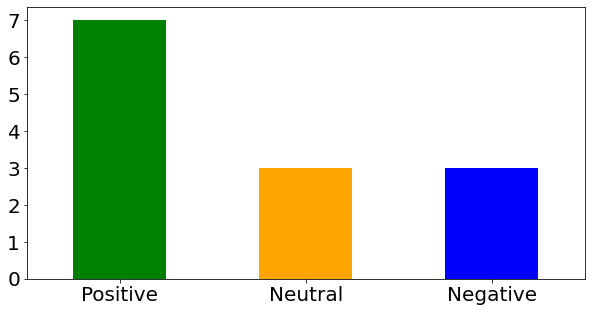

In [56]:
pd.value_counts( df['SENTIMENT'] ).plot.bar( rot=0, color=["green","orange","blue"], fontsize=20, figsize=(10,5) )
print( "Total responses by sentiment" )